# *Load Dataset Directly from Kaggle*

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

In [ ]:
api_token = {"username":"mpyahyazadeh","key":"e7185a8edfd31216e4aa7f59e82701cb"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset

Dataset URL: https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset
License(s): other
100% 3.87G/3.89G [00:32<00:00, 240MB/s]
100% 3.89G/3.89G [00:33<00:00, 126MB/s]


In [ ]:
!unzip /content/semantic-drone-dataset.zip -d data

Archive:  /content/semantic-drone-dataset.zip
  inflating: data/RGB_color_image_masks/RGB_color_image_masks/000.png  
  inflating: data/RGB_color_image_masks/RGB_color_image_masks/001.png  
  inflating: data/RGB_color_image_masks/RGB_color_image_masks/002.png  
  inflating: data/RGB_color_image_masks/RGB_color_image_masks/003.png  
  inflating: data/RGB_color_image_masks/RGB_color_image_masks/004.png  
  inflating: data/RGB_color_image_masks/RGB_color_image_masks/005.png  
  inflating: data/RGB_color_image_masks/RGB_color_image_masks/006.png  
  inflating: data/RGB_color_image_masks/RGB_color_image_masks/008.png  
  inflating: data/RGB_color_image_masks/RGB_color_image_masks/011.png  
  inflating: data/RGB_color_image_masks/RGB_color_image_masks/013.png  
  inflating: data/RGB_color_image_masks/RGB_color_image_masks/014.png  
  inflating: data/RGB_color_image_masks/RGB_color_image_masks/015.png  
  inflating: data/RGB_color_image_masks/RGB_color_image_masks/016.png  
  inflating: data/

# *Preprocessing*

In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

In [ ]:
# Set paths
IMAGE_DIR = "/content/data/dataset/semantic_drone_dataset/original_images"
MASK_DIR = "/content/data/dataset/semantic_drone_dataset/label_images_semantic"

IMG_SIZE = 256
NUM_CLASSES = 23  # Adjust based on the dataset

In [ ]:
def load_images_and_masks(image_dir, mask_dir, img_size):
    images = []
    masks = []
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and resize images
        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0  # Normalize image

        # Load mask in grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

        # Convert mask values to range [0, NUM_CLASSES - 1]
        mask = np.clip(mask, 0, NUM_CLASSES - 1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Reload dataset with corrected masks
images, masks = load_images_and_masks(IMAGE_DIR, MASK_DIR, IMG_SIZE)

# Ensure mask has correct shape and type
masks = masks.reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype(np.int32)

In [ ]:
from sklearn.model_selection import train_test_split

# First, split into training (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)

# Now split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert masks to int
y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)
y_test = y_test.astype(np.int32)

# Create TensorFlow datasets
BATCH_SIZE = 8
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).shuffle(100)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# Print dataset sizes
print(f"Train: {len(X_train)} images")
print(f"Validation: {len(X_val)} images")
print(f"Test: {len(X_test)} images")


Train: 280 images
Validation: 60 images
Test: 60 images


# *visualization*

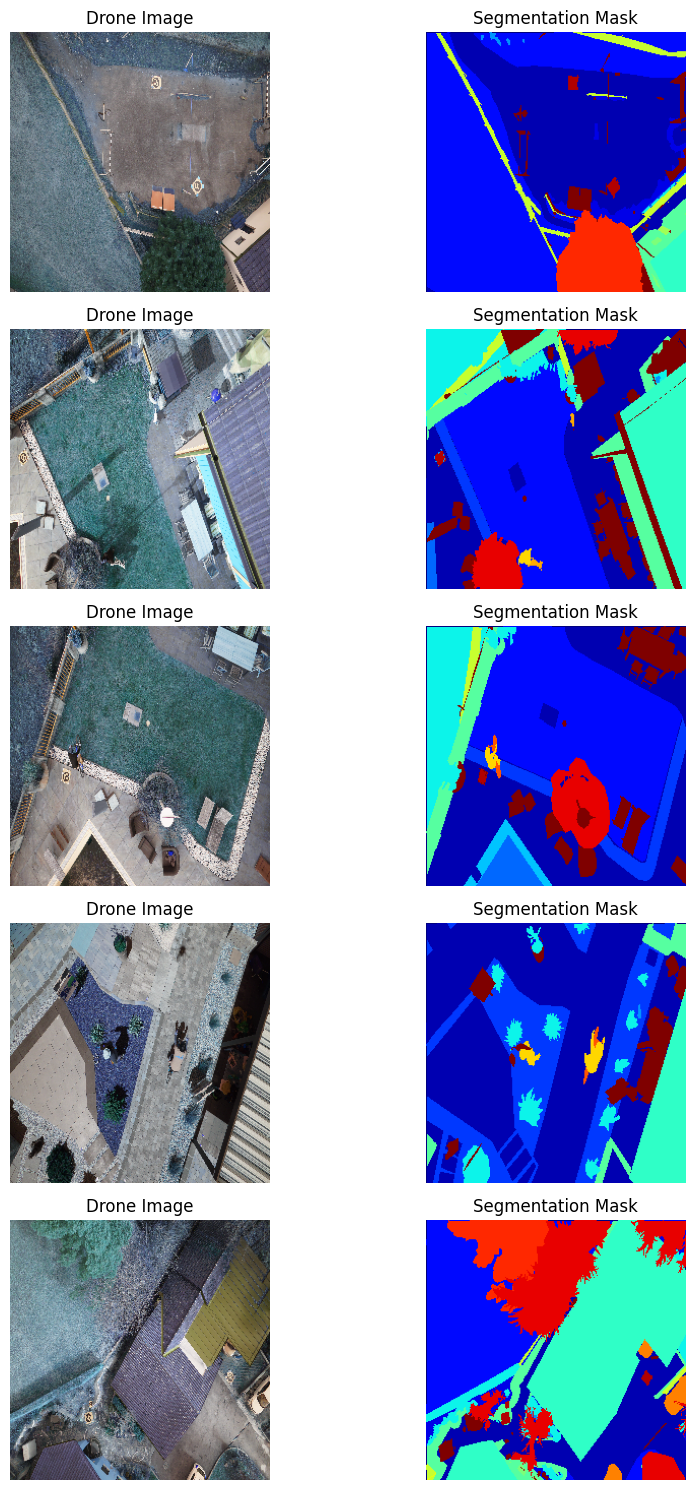

In [ ]:
import matplotlib.pyplot as plt
import random

def visualize_samples(images, masks, num_samples=5):
    """Displays a set of images with their corresponding masks."""
    plt.figure(figsize=(10, num_samples * 3))

    for i in range(num_samples):
        idx = random.randint(0, len(images) - 1)  # Random sample index

        # Image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[idx])
        plt.title("Drone Image")
        plt.axis("off")

        # Mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[idx].squeeze(), cmap="jet")  # Display mask
        plt.title("Segmentation Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call function to visualize dataset
visualize_samples(images, masks, num_samples=5)


# *U_Net model*

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def unet_model(input_shape=(256, 256, 3), num_classes=23):  # Change num_classes if needed
    inputs = layers.Input(shape=input_shape)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder (Upsampling)
    u1 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = layers.concatenate([u1, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = layers.concatenate([u3, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    model = Model(inputs, outputs)
    return model

# Create and compile the model
model = unet_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 256)    │        524,544 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 128, 128, 128)  │        131,200 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)    

 Total params: 7,698,775 (29.37 MB)

 Trainable params: 7,698,775 (29.37 MB)

 Non-trainable params: 0 (0.00 B)

# *Train Model*

In [ ]:
# Create U-Net model
model = unet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES)

# Compile with loss and optimizer
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
EPOCHS = 50
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=EPOCHS)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 393ms/step - accuracy: 0.2789 - loss: 2.7863 - val_accuracy: 0.4038 - val_loss: 2.1123
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step - accuracy: 0.4189 - loss: 2.0367 - val_accuracy: 0.5040 - val_loss: 1.7757
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 363ms/step - accuracy: 0.4800 - loss: 1.8256 - val_accuracy: 0.5310 - val_loss: 1.7037
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.4932 - loss: 1.7097 - val_accuracy: 0.5148 - val_loss: 1.5998
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 359ms/step - accuracy: 0.5507 - loss: 1.5256 - val_accuracy: 0.5668 - val_loss: 1.4819
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 362ms/step - accuracy: 0.5443 - loss: 1.5024 - val_accuracy: 0.5836 - val_loss: 1.4021
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.5764 - loss: 1.3981 - val_accuracy: 0.5591 - val_loss: 1.5126
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - accuracy: 0.5562 - loss: 1.4378 - val_accu

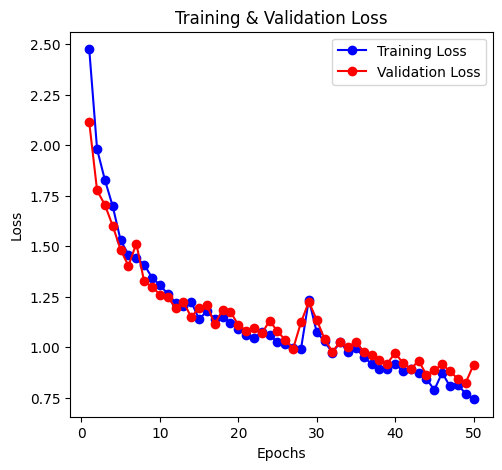

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.show()

# Call the function to plot the history
plot_training_history(history)


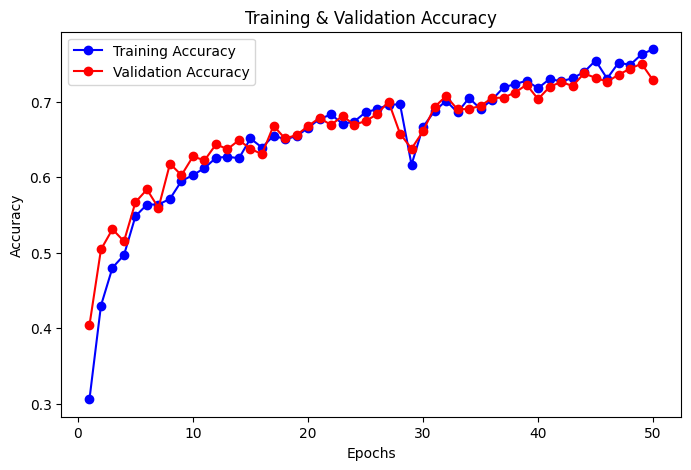

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.show()

# Call function
plot_accuracy(history)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of test images and masks
for img, mask in test_dataset.take(1):  # Take one batch
    pred_mask = model.predict(img)  # Make predictions
    pred_mask = np.argmax(pred_mask, axis=-1)  # Convert to class labels

    img = img.numpy()
    mask = mask.numpy()

    break  # Exit loop after one batch


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


# *Testing Model*

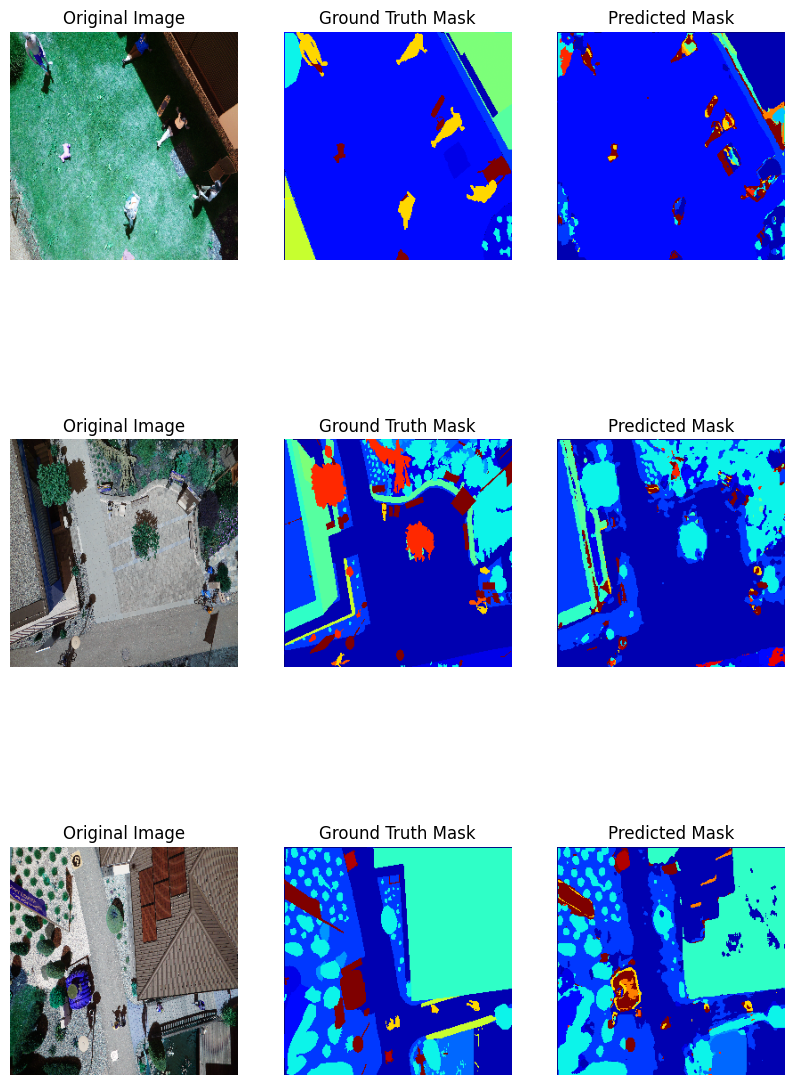

In [ ]:
def display_sample(image, true_mask, pred_mask, num_samples=3):
    plt.figure(figsize=(10, num_samples * 5))

    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image[i])
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask[i], cmap="jet")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask[i], cmap="jet")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.show()

# Display the first few test samples
display_sample(img, mask, pred_mask, num_samples=3)


In [ ]:
# Evaluate on test set
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.7154 - loss: 0.9934
Test Loss: 0.9108
Test Accuracy: 0.7368


# *Saves model in HDF5 format*

In [ ]:
model.save("unet_model.h5")